In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer




In [0]:
!pip install gensim

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
con = sqlite3.connect('./sample_60k.sqlite') 
sample = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
print (sample.head(3))
print (sample.shape)

   level_0   index      Id   ProductId          UserId  \
0    80396  230394  249898  B000H27OQY   A44TW1QDNJVM5   
1    29080  204274  221318  B0009PJRMS  A11YKMMGMN0726   
2   355086  441703  477619  B007FMNZ62   A37XC5PH84JEO   

                                    ProfileName  HelpfulnessNumerator  \
0                                         i8i3d                     0   
1                            N. IBRAHIM "ahmed"                     0   
2  LucianaMachadoMKimonos "LucianaMachadoSimon"                     1   

   HelpfulnessDenominator     Score        Time  \
0                       0  positive  1333411200   
1                       1  positive  1215475200   
2                       1  positive  1340323200   

                                  Summary  \
0                              Excellent!   
1                         Simply the best   
2  As GREAT and the other 5 star ones!!!!   

                                                Text  \
0  Bought this product and it wa

In [0]:
 sample.Score.value_counts()

positive    50662
negative     9338
Name: Score, dtype: int64

In [0]:
sample['Score'] = sample.Score.astype('category')
sample['Score'] = sample.Score.cat.codes
sample.head(3)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,80396,230394,249898,B000H27OQY,A44TW1QDNJVM5,i8i3d,0,0,1,1333411200,Excellent!,Bought this product and it was great. I am an ...,bought product great australian live difficult...
1,29080,204274,221318,B0009PJRMS,A11YKMMGMN0726,"N. IBRAHIM ""ahmed""",0,1,1,1215475200,Simply the best,"The best soap i ever used, it smells great and...",best soap ever use smell great make skin smoot...
2,355086,441703,477619,B007FMNZ62,A37XC5PH84JEO,"LucianaMachadoMKimonos ""LucianaMachadoSimon""",1,1,1,1340323200,As GREAT and the other 5 star ones!!!!,"People sometimes are ""afraid"" of trying new th...",peopl sometim afraid tri new thing see star zi...


In [0]:
# sorting data by time
sample = sample.sort_values(by = 'Time')
sample.head(3)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
43048,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
35945,245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
54900,427,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today find french vhs ...


In [0]:
#seperating labels from final_sample
label = sample.Score
print (label.value_counts())
print (label.head(3))

1    50662
0     9338
Name: Score, dtype: int64
43048    1
35945    1
54900    1
Name: Score, dtype: int8


In [0]:
# train, test split 70:30
X_train = sample.CleanedText[:int(len(sample)*0.6)]
y_train = label[:int(len(sample)*0.6)]

X_cv = sample.CleanedText[int(len(sample)*0.6):int(len(sample)*0.8)]
y_cv = label[int(len(sample)*0.6):int(len(sample)*0.8)]

X_test = sample.CleanedText[int(len(sample)*0.8):]
y_test = label[int(len(sample)*0.8):]

print ('training set :', X_train.shape)
print ('cross-validation set:',X_cv.shape)
print('test set', X_test.shape)
print (X_train.head(2))
print (X_cv.head(2))
print (X_test.head(2))

training set : (36000,)
cross-validation set: (12000,)
test set (12000,)
43048    rememb see show air televis year ago child sis...
35945    one movi movi collect fill comedi action whate...
Name: CleanedText, dtype: object
34089    ive tri varieti cook method work best sprinkl ...
7301     get signific product money didnt particular ca...
Name: CleanedText, dtype: object
47576    awsom buy price product deliv time packag well...
27009    stuff bit spici realli make differ burger fri ...
Name: CleanedText, dtype: object


In [0]:
# BOW vectorizer
# training data
count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_train.values)
print ('the type of count vectorizer' , type(X_train_bow))
print ('shape of text BOW vectorizer' , X_train_bow.get_shape())
print ('Number of unique words',X_train_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (36000, 23810)
Number of unique words 23810


In [0]:
# cross validation and test data
X_cv_bow = count_vec.transform(X_cv.values)
print ('the type of count vectorizer' , type(X_cv_bow))
print ('shape of text BOW vectorizer' , X_cv_bow.get_shape())
print ('Number of unique words',X_cv_bow.get_shape()[1])
print ('**********************************************************')
X_test_bow = count_vec.transform(X_test.values)
print ('the type of count vectorizer' , type(X_test_bow))
print ('shape of text BOW vectorizer' , X_test_bow.get_shape())
print ('Number of unique words',X_test_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (12000, 23810)
Number of unique words 23810
**********************************************************
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (12000, 23810)
Number of unique words 23810


In [0]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

f1 = list()
alpha=[0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
for i in alpha:
    mNB = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    mNB.fit(X_train_bow , y_train)
    pred = mNB.predict(X_cv_bow)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1) 

[0.9276939978028563, 0.9306781701444622, 0.9321905722208218, 0.934634049717738, 0.9039698584818967, 0.9011995238531271, 0.9013001281816517]



 the optimal alpha in mNB is  1.0

 the f1-score for each alpha value is  [0.928 0.931 0.932 0.935 0.904 0.901 0.901]


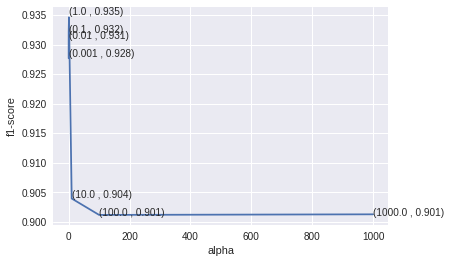

In [0]:


# selcting best alpha 
optimal_alpha = alpha[f1.index(max(f1))]
print ("\n the optimal alpha in mNB is ",optimal_alpha)

# ploting cv_scores and alpha 
plt.plot(alpha , f1)
for xy in zip(alpha , np.round(f1,3)):
  plt.annotate('(%s , %s)' % xy , xy = xy, textcoords = 'data')

plt.xlabel('alpha')
plt.ylabel('f1-score')

print ('\n the f1-score for each alpha value is ',np.round(f1,3))

   

In [0]:
from sklearn.metrics import f1_score
# test accurayc, confusion matrix , precision, recall , f1score with optimal alpha
mNB_optimal = MultinomialNB(alpha = optimal_alpha)
mNB_optimal.fit(X_train_bow , y_train )
pred = mNB_optimal.predict(X_test_bow)
#test accuracy
score = f1_score(y_test , pred)*100
print ('\n the accuracy of multinomial naive bayes classifier with alpha = %f is %f%%' %(optimal_alpha , score))






 the accuracy of multinomial naive bayes classifier with alpha = 1.000000 is 93.875147%


In [0]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test , pred)
cf

array([[1188,  846],
       [ 402, 9564]])

true negative: 1188
false positive 846
false negative 402
true positive 9564


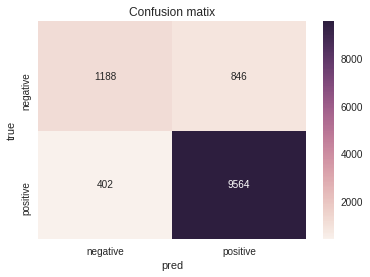

In [0]:
# confusion matrix
import seaborn as sn
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test , pred)
tn, fp, fn, tp = confusion_matrix(y_test , pred).ravel()
print ("true negative:" ,tn)
print ('false positive',fp)
print ('false negative',fn)
print ('true positive',tp)
labels = ['negative', 'positive']
conf_matrix_df = pd.DataFrame(conf_matrix , index = labels , columns = labels)
sn.heatmap(conf_matrix_df, annot = True, fmt = 'd')
plt.title('Confusion matix')
plt.xlabel('pred')
plt.ylabel('true')
plt.show()



In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test , pred))


              precision    recall  f1-score   support

           0       0.75      0.58      0.66      2034
           1       0.92      0.96      0.94      9966

   micro avg       0.90      0.90      0.90     12000
   macro avg       0.83      0.77      0.80     12000
weighted avg       0.89      0.90      0.89     12000



In [0]:
from sklearn.metrics import accuracy_score 

accuracy_score(y_test , pred)

0.896

In [0]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def important_features(vectorizer,classifier,n=20):
  class_labels = classifier.classes_
  feature_names =vectorizer.get_feature_names()
  topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n]
  topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]
  print("Important words in negative reviews")
  for coef, feat in topn_class1:
    print(class_labels[0], coef, feat)
  print("-----------------------------------------")
  print("Important words in positive reviews")
  for coef, feat in topn_class2:
    print(class_labels[1], coef, feat) 

In [0]:
important_features(count_vec ,mNB_optimal,n=10 )

Important words in negative reviews
0 -4.317056018519025 tast
0 -4.382706618414052 like
0 -4.540671527680429 product
0 -4.833876296614862 one
0 -4.912864707933491 flavor
0 -4.945939959615278 would
0 -4.997388521451319 tri
0 -5.1435997875063855 good
0 -5.202070009925794 use
0 -5.251279469304251 get
-----------------------------------------
Important words in positive reviews
1 -4.4547636267824835 like
1 -4.533818041157966 tast
1 -4.648657712553851 good
1 -4.700341627458542 flavor
1 -4.717775303422357 love
1 -4.757078339889272 great
1 -4.767346876647698 use
1 -4.8299147989957465 one
1 -4.853420380931686 tea
1 -4.9003588215598 product


In [0]:
#tfidf sparse
tfidf_vect = TfidfVectorizer(ngram_range=(1,2)) #in scikit-learn
# training data
X_train_TS = tfidf_vect.fit_transform(X_train.values)
print ('the type of count vectorizer' , type(X_train_TS))
print ('shape of text tfidf vectorizer' , X_train_TS.get_shape())
print ('Number of unique words',X_train_TS.get_shape()[1])

# cross validation data
X_cv_TS = tfidf_vect.transform(X_cv.values)
print ('the type of count vectorizer' , type(X_cv_TS))
print ('shape of cv tfidf vectorizer' , X_cv_TS.get_shape())
print ('Number of unique words',X_cv_TS.get_shape()[1])

# test data
X_test_TS = tfidf_vect.transform(X_test.values)
print ('the type of count vectorizer' , type(X_test_TS))
print ('shape of text tfidf vectorizer' , X_test_TS.get_shape())
print ('Number of unique words',X_test_TS.get_shape()[1])


the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text tfidf vectorizer (6000, 151815)
Number of unique words 151815
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of cv tfidf vectorizer (2000, 151815)
Number of unique words 151815
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text tfidf vectorizer (2000, 151815)
Number of unique words 151815


In [0]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

f1 = list()
alpha=[0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
for i in alpha:
    mNB = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    mNB.fit(X_train_TS , y_train)
    pred = mNB.predict(X_cv_TS)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1) 

[0.9048943270300334, 0.908431044109436, 0.9000825763831544, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705]



 the optimal alpha in mNB is  0.01

 the f1-score for each alpha value is  [0.905 0.908 0.9   0.9   0.9   0.9   0.9  ]


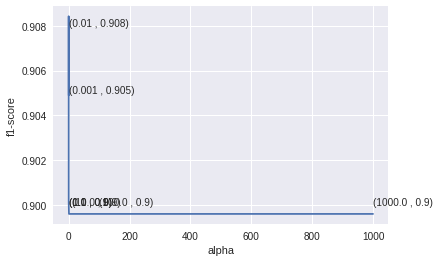

In [0]:


# selcting best alpha 
optimal_alpha = alpha[f1.index(max(f1))]
print ("\n the optimal alpha in mNB is ",optimal_alpha)

# ploting cv_scores and alpha 
plt.plot(alpha , f1)
for xy in zip(alpha , np.round(f1,3)):
  plt.annotate('(%s , %s)' % xy , xy = xy, textcoords = 'data')

plt.xlabel('alpha')
plt.ylabel('f1-score')

print ('\n the f1-score for each alpha value is ',np.round(f1,3))


   

In [0]:
from sklearn.metrics import f1_score
# test accurayc, confusion matrix , precision, recall , f1score with optimal alpha
mNB_optimal = MultinomialNB(alpha = optimal_alpha)
mNB_optimal.fit(X_train_TS , y_train )
pred = mNB_optimal.predict(X_test_TS)
#test accuracy
score = f1_score(y_test , pred)*100
print ('\n the accuracy of multinomial naive bayes classifier with alpha = %f is %f%%' %(optimal_alpha , score))


 the accuracy of multinomial naive bayes classifier with alpha = 0.010000 is 91.815145%


In [0]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test , pred)
cf

array([[  57,  276],
       [  18, 1649]])

true negative: 57
false positive 276
false negative 18
true positive 1649


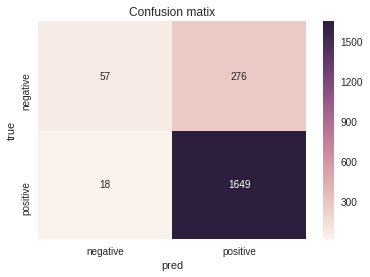

In [0]:
# confusion matrix
import seaborn as sn
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test , pred)
tn, fp, fn, tp = confusion_matrix(y_test , pred).ravel()
print ("true negative:" ,tn)
print ('false positive',fp)
print ('false negative',fn)
print ('true positive',tp)
labels = ['negative', 'positive']
conf_matrix_df = pd.DataFrame(conf_matrix , index = labels , columns = labels)
sn.heatmap(conf_matrix_df, annot = True, fmt = 'd')
plt.title('Confusion matix')
plt.xlabel('pred')
plt.ylabel('true')
plt.show()



In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test , pred))


              precision    recall  f1-score   support

           0       0.75      0.58      0.66      2034
           1       0.92      0.96      0.94      9966

   micro avg       0.90      0.90      0.90     12000
   macro avg       0.83      0.77      0.80     12000
weighted avg       0.89      0.90      0.89     12000



In [0]:
from sklearn.metrics import accuracy_score 

accuracy_score(y_test , pred)

0.896

In [0]:
important_features(tfidf_vect ,mNB_optimal,n=10 )

Important words in negative reviews
0 -4.317056018519025 case dont
0 -4.382706618414052 better ear
0 -4.540671527680429 breath coat
0 -4.833876296614862 bottl littl
0 -4.912864707933491 away amazon
0 -4.945939959615278 chili obvious
0 -4.997388521451319 cereal grandaught
0 -5.1435997875063855 bag kind
0 -5.202070009925794 check sorbet
0 -5.251279469304251 bad price
-----------------------------------------
Important words in positive reviews
1 -4.4547636267824835 better ear
1 -4.533818041157966 case dont
1 -4.648657712553851 bag kind
1 -4.700341627458542 away amazon
1 -4.717775303422357 betti drop
1 -4.757078339889272 bag white
1 -4.767346876647698 check sorbet
1 -4.8299147989957465 bottl littl
1 -4.853420380931686 case must
1 -4.9003588215598 breath coat


In [1]:
! pip install PTable
from prettytable import PrettyTable

  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [4]:
x = PrettyTable()
x.field_names=['Vectorizer','Hyper-parameter','f1-score']

x.add_row(['BOW',1.0,0.93])
x.add_row(['tfidf',0.01,0.91])
print (x)

+------------+-----------------+----------+
| Vectorizer | Hyper-parameter | f1-score |
+------------+-----------------+----------+
|    BOW     |       1.0       |   0.93   |
|   tfidf    |       0.01      |   0.91   |
+------------+-----------------+----------+
